In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
PATH = "C:/Users/rahul/Desktop/Final Year Project/Datasets"
T1 = PATH + "/Inputs & output.xlsx"

In [4]:
data = pd.read_excel(T1, header = 1)

In [5]:
data = data.drop("Number", axis=1)
data = data.drop("Biomass type", axis=1)

In [6]:
data

,M,VM,FC,A,C,O,H,N,S,T (˚C),AFR (kg/kg),Wnet (kW)
0,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,1.8,50.646995
1,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.0,47.490069
2,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.3,44.021257
3,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,1.8,103.090293
4,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,2.0,98.030617
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.0,65.234100
1028,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.3,57.348570
1029,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,1.8,96.825749
1030,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,2.0,92.012450


In [7]:
X = data.iloc[:, :11]
X = X.to_numpy(dtype=float)
X.shape

(1032, 11)

In [8]:
X[2]

array([5.26000e+01, 7.66000e+01, 1.92000e+01, 4.20000e+00, 5.09656e+01,
       3.85116e+01, 5.84380e+00, 4.79000e-01, 0.00000e+00, 6.00000e+02,
       2.30000e+00])

In [9]:
Y = data.iloc[:, 11:]
Y = Y.to_numpy(dtype=float)
Y.shape

(1032, 1)

In [10]:
Y[2]

array([44.0212568])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 Ti'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/5, random_state = 1)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [13]:
X_test[2]

array([-0.34353008, -0.17485219, -0.24360851, -0.35638173, -0.20954265,
       -0.23296478, -0.34601559, -0.36100575, -0.36506559,  4.45399026,
       -0.35895206])

In [14]:
y_test[2]

array([240.816006])

In [15]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

train_ds = TensorDataset(X_train, y_train)
#test_ds = TensorDataset(X_test, y_test)
torch.manual_seed(1)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.firstlayer = nn.Linear(input_size, hidden_size)
        self.secondlayer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.firstlayer(x)
        x = nn.Sigmoid()(x)
        x = self.secondlayer(x)
        return x

    def predict(self, x):
        pred = self.forward(x)
        return pred

In [16]:
network = NeuralNetwork(11, 40, 1).to(device)

In [17]:
network

NeuralNetwork(
  (firstlayer): Linear(in_features=11, out_features=40, bias=True)
  (secondlayer): Linear(in_features=40, out_features=1, bias=True)
)

In [18]:
num_epochs = 10000
log_epochs = 100
learning_rate = 0.0002
lossfunc = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_hist = [0] * num_epochs
accuracy_hist = [0]*num_epochs

In [19]:
for epochs in range(num_epochs):
    count = 0
    for x, y in train_dl:
        prediction = network.predict(x)
        loss = lossfunc(prediction, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epochs] += loss.item()*y.size(0)
        if(torch.abs(prediction - y) <= torch.tensor(20)): count += 1
        
    loss_hist[epochs] /= len(train_dl.dataset)
    accuracy_hist[epochs] = count/len(train_dl.dataset)
    if epochs % log_epochs==0:
        print(f'Epoch {epochs} Loss 'f'{loss_hist[epochs]:.4f}')
        print(f'Epoch {epochs} Accuracy 'f'{accuracy_hist[epochs]:.4f}')

Epoch 0 Loss 29556.2243
Epoch 0 Accuracy 0.0764
Epoch 100 Loss 4925.5797
Epoch 100 Accuracy 0.2703
Epoch 200 Loss 4732.0391
Epoch 200 Accuracy 0.2752
Epoch 300 Loss 4622.7527
Epoch 300 Accuracy 0.2776
Epoch 400 Loss 4487.3874
Epoch 400 Accuracy 0.2885
Epoch 500 Loss 4325.3171
Epoch 500 Accuracy 0.2933
Epoch 600 Loss 4136.1684
Epoch 600 Accuracy 0.2970
Epoch 700 Loss 3936.4585
Epoch 700 Accuracy 0.3030
Epoch 800 Loss 3746.7869
Epoch 800 Accuracy 0.3006
Epoch 900 Loss 3567.5432
Epoch 900 Accuracy 0.3139
Epoch 1000 Loss 3402.3679
Epoch 1000 Accuracy 0.3188
Epoch 1100 Loss 3249.7700
Epoch 1100 Accuracy 0.3345
Epoch 1200 Loss 3111.5856
Epoch 1200 Accuracy 0.3455
Epoch 1300 Loss 2980.7885
Epoch 1300 Accuracy 0.3612
Epoch 1400 Loss 2857.5225
Epoch 1400 Accuracy 0.3697
Epoch 1500 Loss 2742.7886
Epoch 1500 Accuracy 0.3782
Epoch 1600 Loss 2633.6121
Epoch 1600 Accuracy 0.3927
Epoch 1700 Loss 2523.3295
Epoch 1700 Accuracy 0.4012
Epoch 1800 Loss 2426.3537
Epoch 1800 Accuracy 0.4097
Epoch 1900 Loss 

In [33]:
test_predictions = network.predict(X_test)

In [17]:
y_test[100]

Error: Canceled future for execute_request message before replies were done

In [37]:
test_predictions[100]   

tensor([269.2975], device='cuda:0', grad_fn=<SelectBackward0>)

In [38]:
torch.save(network.state_dict(), "modelStateDict.pth")

In [32]:
import pickle
with open('loss.pickle', 'wb') as f:
    pickle.dump(loss_hist, f)
with open('accuracy.pickle', 'wb') as f:
    pickle.dump(accuracy_hist, f)

In [7]:
import pickle
pickle_in = open('loss.pickle', 'rb')
loss_hist = pickle.load(pickle_in)
pickle_in1 = open('accuracy.pickle', 'rb')
accuracy_hist = pickle.load(pickle_in1)

Text(0, 0.5, 'Loss Value')

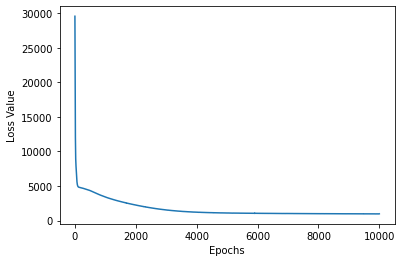

In [8]:
plt.plot(loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss Value')

Text(0, 0.5, 'Accuracy Value')

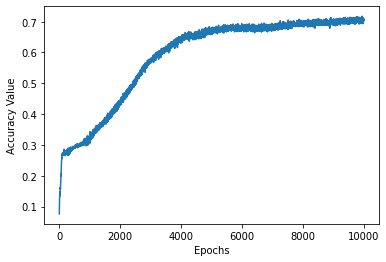

In [9]:
plt.plot(accuracy_hist)
plt.xlabel('Epochs')
plt.ylabel('Accuracy Value')

In [11]:
loss_hist[9999]

961.5006592499307

In [12]:
accuracy_hist[9999]

0.7042424242424242